# Testing stock

* 時間, `最近成交價`, `當盤成交量`, `累積成交量`, `最佳五檔（賣價）`, `最佳五檔（賣量）`, `最佳五檔（買價）`, `最佳五檔（買量）`

In [1]:
import re
import numpy as np

def getDataset(path):
    dataset = []
    with open(path, 'r') as fp:
        for i in range(500):
            data = fp.readline()
            if len(data) == 0:
                break
            data = data.replace('-', '0')
            data = re.split(',|\n', data)[1:-1]
            data[3] = data[3].split('_')[0]
            data[4] = data[4].split('_')[0]
            data[5] = data[5].split('_')[0]
            data[6] = data[6].split('_')[0]
            try:
                dataset.append(np.asarray(data, dtype=np.float))
            except ValueError:
                print(data)
                
    return np.asarray(dataset)

def countDataset(path):
    return len(getDataset(path))

# get all paths and summary

500 1901


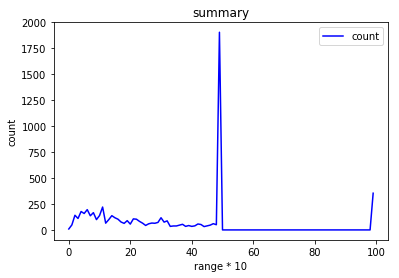

In [2]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
dataset_path = "./dataset/Taiwan_5s/"

min_count = 65535
choose = 500
input_days = 15
output_days = 1

summary = [0] * 100
paths = []

for dirPath, dirNames, fileNames in os.walk(dataset_path):
    if dirPath == dataset_path:
        continue
    total = 0
    for datapath in fileNames:
        count = countDataset(dirPath + '/' + datapath)
        summary[count // 10 - 1] += 1
        if count == choose:
            paths.append(dirPath + '/' + datapath)
print(choose, len(paths))
# plot results
plt.plot(summary, color = 'blue', label = 'count')
plt.title('summary')
plt.xlabel('range * 10')
plt.ylabel('count')
plt.legend()
plt.show()

# My own MinMaxScaler

In [3]:
class MinMaxScaler:
    __min = 0.
    __max = 1.
    __range = 1.
    __feature_range = (0, 1)
    __scale = 1.
    def __init__(self):
        pass
    def getScalerData(self, dataset, offset=0.1, feature_range=(0, 1)):
        data_max = np.max(dataset)
        data_min = np.min(dataset)
        if len(dataset) == 1:
            range_temp = dataset * offset
        else:
            range_temp = (data_max - data_min) * (1 + offset)
        self.__min = data_max - range_temp
        self.__max = data_min + range_temp
        self.__range = self.__max - self.__min
        self.__feature_range = feature_range
        self.__scale = (feature_range[1] - feature_range[0]) / self.__range
        return self.getTransformData(dataset)
    def getTransformData(self, dataset):
        return (dataset - self.__min) * self.__scale + self.__feature_range[0]
    def getInverseData(self, scalerDataset):
        return (scalerDataset - self.__feature_range[0]) / self.__scale + self.__min
    def getParameter(self):
        return self.__min, self.__max, self.__range, self.__feature_range, self.__scale
    def updatePatameter(self, parameter):
        self.__min, self.__max, self.__range, self.__feature_range, self.__scale = parameter

# create dataset
* 1. price use MinMaxScaler with offset 0.1
* 2. trading volume using local MinMaxScaler
* 3. best 1 sell price use MinMaxScaler in 1.
* 4. best 1 buy price use MinMaxScaler in 1.
* 5. if sell count > buy count than > 0.5

In [4]:
from tensorflow.keras.utils import to_categorical

def create_dataset(path, input_days=60, output_days=1):
    dataset = getDataset(path)
    price_sc = MinMaxScaler()
    price_sc.getScalerData(np.array([dataset[0][0]]), offset=0.1, feature_range=(0, 1))
    prices = price_sc.getTransformData(dataset[:, [0, 3, 5]])
    output = []
    label = []
    for i in range(input_days, choose - output_days + 1):
        temp = dataset[i-input_days:i]
        # create total set
        temp_sc = MinMaxScaler()
        a = prices[i-input_days:i]
        diff = prices[i, 0] - prices[i-1, 0]
        if diff > 0:
            y = 2
        elif diff < 0:
            y = 0
        else :
            y = 1
        b = temp_sc.getScalerData(temp[:, 1:2])
        sell_count = temp[:, 4:5]
        buy_count = temp[:, 6:7]
        temp_scale = np.absolute(sell_count - buy_count) / np.maximum(sell_count, buy_count) / 2
        c = np.where(sell_count > buy_count, 0.5+temp_scale, 0.5-temp_scale)
        output.append(np.append(np.append(a, b, axis=-1), c, axis=-1))
        label.append(y)
    output = np.asarray(output, dtype=np.float)
    label = to_categorical(np.asarray(label, dtype=np.float), num_classes=3)
    return output, label, price_sc.getParameter()

In [5]:
x = np.empty((0, input_days, 5), dtype=np.float)
y = np.empty((0, 3), dtype=np.float)

for i, path in enumerate(paths):
    if i > 1500:
        break
    if i < 15 :
        continue
    x_temp, y_temp, sc_parameter = create_dataset(path=path, input_days=input_days, output_days=output_days)
    x = np.append(x, x_temp, axis=0)
    y = np.append(y, y_temp, axis=0)

print(x.shape, y.shape)

C:\Users\DVLAB\AppData\anaconda3\envs\dlib\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\DVLAB\AppData\anaconda3\envs\dlib\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply


(720710, 15, 5) (720710, 3)


In [6]:
x[np.isnan(x)] = 0

# Create model

In [7]:
RADAM = False
if RADAM:
    from keras_radam import RAdam
    from keras_lookahead import Lookahead
    optimizer = Lookahead(RAdam())
else:
    optimizer = 'adam'
    
period = 25
epochs = 250
batch_size = 3000

In [8]:
# LSTM Training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import CuDNNLSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import plot_model

model = Sequential()

model.add(CuDNNLSTM(units = 50, return_sequences = True, input_shape = (input_days, 5)))
model.add(CuDNNLSTM(units = 50, return_sequences = True))
model.add(CuDNNLSTM(units = 50, return_sequences = True))
model.add(Flatten())
model.add(Dense(units = 128, activation='relu'))
model.add(Dense(units = 40, activation='relu'))
model.add(Dense(units = 3, activation='softmax'))
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy')
model.summary()
plot_model(model, 'model.png')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 15, 50)            11400     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 15, 50)            20400     
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 15, 50)            20400     
_________________________________________________________________
flatten (Flatten)            (None, 750)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               96128     
_________________________________________________________________
dense_1 (Dense)              (None, 40)                5160      
_________________________________________________________________
dens

# Training the model

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os
name = 'model_02'
checkpoint_file = './model/' + name + '_check_point/cp-{epoch:04d}.ckpt'
try:
    os.mkdir('./model/' + name + '_check_point/')
except:
    pass

# create callback function
cp_callback = ModelCheckpoint(checkpoint_file, save_weights_only=True, verbose=1, period=period)

# train the model
train = model.fit(x, y, epochs=epochs, batch_size=batch_size, callbacks=[cp_callback], validation_split=0.2)

# save model
model.save('./model/' + name + '.h5')

Train on 576568 samples, validate on 144142 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/250
576568/576568 [==============================] - 8s 13us/sample - loss: 0.7197 - val_loss: 0.7338
Epoch 2/250
576568/576568 [==============================] - 3s 5us/sample - loss: 0.7076 - val_loss: 0.7305
Epoch 3/250
576568/576568 [==============================] - 3s 5us/sample - loss: 0.7053 - val_loss: 0.7294
Epoch 4/250
576568/576568 [==============================] - 3s 5us/sample - loss: 0.7035 - val_loss: 0.7267
Epoch 5/250
576568/576568 [==============================] - 3s 5us/sample - loss: 0.7028 - val_loss: 0.7260
Epoch 6/250
576568/576568 [==============================] - 3s 5us/sample - loss: 0.7017 - val_loss: 0.7256
Epoch 7/250
576568/576568 [==============================] - 3s 5us/sample - loss: 0.7010 - val_loss: 0.7253
Epoch 8/250
576568/576568 [==============================] - 3s 5us/sample - loss: 0.7008 - val_loss: 0.7249
Epoch 9/250
576568/576568 [

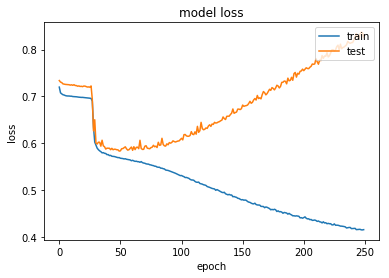

In [10]:
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [42]:
model.load_weights('./model/model_02_check_point/cp-{epoch:04d}.ckpt'.format(epoch=50))
test_x, test_y, sc_parameter = create_dataset(path=paths[1550], input_days=input_days, output_days=output_days)
test_x[np.isnan(test_x)] = 0
pred = np.argmax(model.predict(test_x), axis=-1)
print(pred.shape, pred)

(485,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


C:\Users\DVLAB\AppData\anaconda3\envs\dlib\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\DVLAB\AppData\anaconda3\envs\dlib\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply


(485,)


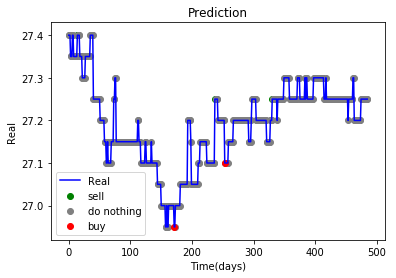

In [43]:
test_sc = MinMaxScaler()
test_sc.updatePatameter(sc_parameter)
test_real = test_x[:, -1, 0]
test_real = test_sc.getInverseData(test_real)
output_action = pred
print(test_real.shape)

# Visualising the results
plot = test_real
sell = np.where(output_action==0)
do_nothing = np.where(output_action==1)
buy = np.where(output_action==2)
plt.plot(plot, color = 'blue', label = 'Real')
plt.scatter(sell, plot[sell], color = 'green', label = 'sell')
plt.scatter(do_nothing, plot[do_nothing], color = 'gray', label = 'do nothing')
plt.scatter(buy, plot[buy], color = 'red', label = 'buy')
# plt.plot(output_prices, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Prediction')
plt.xlabel('Time(days)')
plt.ylabel('Real')
plt.legend()
plt.show()